In [1]:
import pandas as pd
import numpy as np  # TODO: change isnan to math.isnan
from pyomo.environ import *
import openpyxl

from analysis import restore_plots
from gen_utils import cnf_tools

In [2]:
# Get model configuration
path = "data/model_config/restore_cnf_v1.xlsx"
data_handler = cnf_tools.ConfigHandler(path)

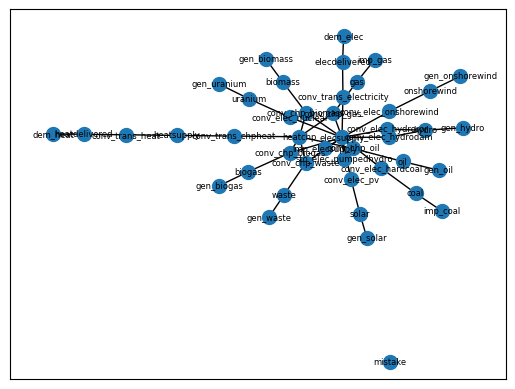

In [3]:
# Show network complexity if there is a connection issue
in_df = data_handler.io_cnf["input_eff"].droplevel(0)
out_df = data_handler.io_cnf["output_eff"].droplevel(0)
in_df["mistake"] = np.nan
out_df["mistake"] = np.nan
restore_plots.plot_io_network(in_df, out_df)

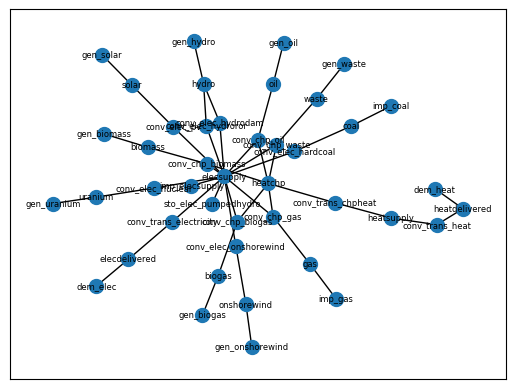

In [4]:
# Show network complexity
in_df = data_handler.io_cnf["input_eff"].droplevel(0)
out_df = data_handler.io_cnf["output_eff"].droplevel(0)
restore_plots.plot_io_network(in_df, out_df)

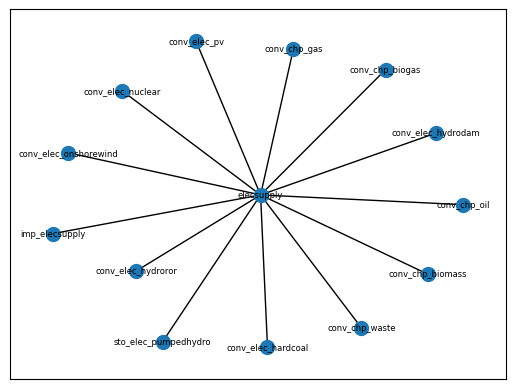

In [5]:
# Show network complexity of regular D-EXPANSE
dxp_tech = ["conv_chp_biogas","conv_chp_biomass","conv_chp_gas","conv_chp_oil","conv_chp_waste",
            "conv_elec_hardcoal","conv_elec_hydrodam","conv_elec_hydroror","conv_elec_nuclear",
            "conv_elec_onshorewind","conv_elec_pv","sto_elec_pumpedhydro", "imp_elecsupply"]
dxp_flow = ["elecsupply"]

dxp_in_df = data_handler.io_cnf["input_eff"].droplevel(0).loc[dxp_tech, dxp_flow]
dxp_out_df = data_handler.io_cnf["output_eff"].droplevel(0).loc[dxp_tech, dxp_flow]
restore_plots.plot_io_network(dxp_in_df, dxp_out_df)

In [6]:
# Configuration
n_days = 2

In [7]:
# Create model sets
# Temporal
years = list(range(1990, 1995))
hours = list(range(n_days*24))  # NOTE: consider separating into day sets and hour sets

# Processes
conversions = set(in_df[in_df.index.str.startswith("conv_")].index)
generations = set(in_df[in_df.index.str.startswith("gen_")].index)
imports = set(in_df[in_df.index.str.startswith("imp_")].index)
storages = set(in_df[in_df.index.str.startswith("sto_")].index)

# Demands
demands = set(in_df[in_df.index.str.startswith("dem_")].index)

processes = conversions | generations | imports | storages
elements = processes | demands

# Flows
flows = set(in_df.columns)

# Combinations
fout_e = cnf_tools.get_flow_element_dict(out_df.loc[~out_df.index.isin(demands)])
fin_e = cnf_tools.get_flow_element_dict(in_df.loc[~in_df.index.isin(generations)])
f_e = cnf_tools.merge_dicts(fout_e, fin_e)

e_fout = cnf_tools.get_flow_element_dict(out_df.loc[~out_df.index.isin(demands)], by_element=True)
e_fin = cnf_tools.get_flow_element_dict(in_df.loc[~in_df.index.isin(generations)], by_element=True)
e_f = cnf_tools.merge_dicts(e_fout, e_fin)

In [8]:
# Sets for special cases
chp_conversions = {i for i in conversions if "_chp_" in i}  # distinct capacity characteristics
vre_conversions = set(c for c in conversions for vre in ["onshorewind", "pv", "offshorewind"] if vre in c)

# Sets

In [9]:
# Initialise model
model = ConcreteModel()

# Indices 1xN
model.Years = Set(initialize=years, ordered=True)
model.Y0 = Set(initialize=[years[0]], ordered=True)
model.Hours = Set(initialize=hours, ordered=True)
model.H0 = Set(initialize=[hours[0]], ordered=True)

model.Convs = Set(initialize=conversions, ordered=False)
model.Gens = Set(initialize=generations, ordered=False)
model.Imps = Set(initialize=imports, ordered=False)
model.Stors = Set(initialize=storages, ordered=False)

model.Dems = Set(initialize=demands, ordered=False)

model.Pros = Set(initialize=processes, ordered=False)

model.Elems = Set(initialize=elements, ordered=False)
model.Flows = Set(initialize=flows, ordered=False)

# Special cases
model.ProsGeneric = Set(initialize=processes-chp_conversions, ordered=False)
model.ConvsVRE = Set(initialize=vre_conversions, ordered=False)


In [10]:
# Cartesian subsets
# See https://github.com/brentertainer/pyomo-tutorials/blob/master/intermediate/05-indexed-sets.ipynb
# Indices FxE with all
model.FiE = Set(within=model.Flows*model.Elems, ordered=False, 
                  initialize={(f, p) for f in flows for p in fin_e[f]})
model.FoE = Set(within=model.Flows*model.Elems, ordered=False, 
                   initialize={(f, p) for f in flows for p in fout_e[f]})
model.FxE = Set(within=model.Flows*model.Elems, ordered=False,
                initialize={(f, p) for f in flows for p in f_e[f]})

# Special cases
model.FoEchp = Set(within=model.Flows*model.Elems, ordered=False, 
                   initialize={(f, p) for f in flows for p in fout_e[f] if p in chp_conversions})
model.FoEgeneric = Set(within=model.Flows*model.Elems, ordered=False, 
                       initialize={(f, p) for f in flows for p in fout_e[f] if p not in chp_conversions})

# Parameters

In [11]:
model.NDAYS = Param(initialize=n_days)
model.TPERIOD = Param(initialize=365/n_days)

# Variables

In [12]:
# Capacity
model.ctot = Var(model.Pros, model.Years, domain=NonNegativeReals)
model.cnew = Var(model.Pros, model.Years, domain=NonNegativeReals)
model.cret = Var(model.Pros, model.Years, domain=NonNegativeReals)

# Process activity
model.a = Var(model.Gens | model.Convs | model.Stors, model.Years, model.Hours, domain=NonNegativeReals)
model.aimp = Var(model.Imps, model.Years, model.Hours, domain=NonNegativeReals)
model.aexp = Var(model.Imps, model.Years, model.Hours, domain=NonNegativeReals)

# Flows
model.fin = Var(model.FiE, model.Years, model.Hours, domain=NonNegativeReals)
model.fout = Var(model.FoE, model.Years, model.Hours, domain=NonNegativeReals)


# Constraints
## In-out flow

Input - Output balance

In [13]:
def c_inoutbalance(mod, flow, year, hour):
    f_out_of_e = sum(model.fout[f, e, year, hour] for (f, e) in model.FoE if f == flow)
    f_into_e = sum(model.fin[f, e, year, hour] for (f, e) in model.FiE if f == flow)
    return  f_out_of_e == f_into_e

model.c_inoutbalance = Constraint(model.Flows, model.Years, model.Hours, rule=c_inoutbalance)

In flow efficiency

In [14]:
i_eff = data_handler.ef_stack["input_eff"].to_dict()
i_fac = data_handler.ef_stack["input_factor"].to_dict()
i_rat = data_handler.ef_stack["input_ratio"].to_dict()

def c_flowin(mod, process, year, hour):
    if process in mod.Imps:
        if data_handler.check_process_cnf(process, "enable_export"):
            x = model.aexp[process, year, hour]
        else:
            return Constraint.Skip
    else:
        x = model.a[process, year, hour]
    x = x == sum(model.fin[f,e,year, hour]*i_eff[e, f]*i_fac[e, f]*i_rat[e, f] for (f, e) in model.FiE if e == process)
    return x

model.c_flowin = Constraint(model.Convs | model.Stors | model.Imps , model.Years, model.Hours, rule=c_flowin)

In [15]:
o_eff = data_handler.ef_stack["output_eff"].to_dict()
o_fac = data_handler.ef_stack["output_factor"].to_dict()
o_rat = data_handler.ef_stack["output_ratio"].to_dict()

def c_flowout(mod, process, year, hour):
    if process in mod.Imps:
        if data_handler.check_process_cnf(process, "enable_import"):
            x = mod.aimp[process, year, hour]
        else:
            return Constraint.Skip
    else:
        x = mod.a[process, year, hour]
    x = x == sum(mod.fout[f,e,year, hour]*o_eff[e, f]*o_fac[e, f]*o_rat[e, f] for (f, e) in mod.FoE if e == process)
    return x
model.c_flowout = Constraint(model.ProsGeneric, model.Years, model.Hours, rule=c_flowout)

In [16]:
def c_flowoutchp(mod, flow, process, year, hour):
    coeff = o_eff[process, flow]*o_fac[process, flow]*o_rat[process, flow]
    if flow == "elecsupply":
        return mod.fout[flow, process, year, hour] == coeff*mod.a[process, year, hour]
    elif flow == "heatchp":
        # Allow heat curtailing
        return mod.fout[flow, process, year, hour] <= coeff*mod.a[process, year, hour]
    else:
        raise KeyError("Invalid output flow  in 'model.FoEchp' builder:", flow)

model.c_flowoutchp = Constraint(model.FoEchp, model.Years, model.Hours, rule=c_flowoutchp)

## Capacity

Maximum capacity constraint

$$\forall{p \in P, y \in Y} \quad ctot_{p, y} ≤ \text{max\_capacity\_annual}$$

In [17]:
def c_capmax(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        cap_max = data_handler.get_process_const(process, "max_capacity_annual")
        if np.isnan(cap_max):  # Allow infinite capacity?
            return Constraint.Skip
        return mod.ctot[process, year] <= cap_max
    else:
        return Constraint.Skip

model.c_capmax = Constraint(model.Pros, model.Years, rule=c_capmax)

Capacity transfer
$$\forall{p \in P, y \in Y \setminus Y_{0}} \quad ctot_{p,y} = ctot_{p,y-1} + cnew_{p,y} + cret_{p,y}$$

In [18]:
def c_captrans(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        total_capacity = mod.ctot[process, year-1] + mod.cnew[process, year] - mod.cret[process, year]
        return mod.ctot[process, year] == total_capacity
    else:
        return Constraint.Skip
model.c_captrans = Constraint(model.Pros, model.Years-model.Y0, rule=c_captrans)

Capacity retirement

In [19]:
def c_capret(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        life = data_handler.get_process_const(process, "lifetime")
        cnf_retired = data_handler.get_process_value(process, "initial_retired_capacity", year)
        if any(np.isnan([life, cnf_retired])):
            cnf_retired = 0
        elif life <= year - mod.Years.first():
            cnf_retired -= mod.cnew[process, year - life]
        
        # It is possible to enable capacity, but disallow any retirements by keeping 'lifetime' disabled.
        return mod.cret[process, year] == cnf_retired
    else:
        return Constraint.Skip
    
model.c_capret = Constraint(model.Pros, model.Years-model.Y0, rule=c_capret)

Buildrate

In [20]:
def c_capbuildrate(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        buildrate = data_handler.get_process_const(process, "buildrate")
        if np.isnan(buildrate):
            return Constraint.Skip
        else:
            return mod.cnew[process, year] <= buildrate
    return Constraint.Skip

model.c_capbuildrate = Constraint(model.Pros, model.Years, rule=c_capbuildrate)

## Generation/Activity constraints
Ramping limits

In [21]:
def c_rampup(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        ramp = data_handler.get_process_const(process, "ramp_rate")
        if np.isnan(ramp) or ramp > 1:
            # No ramping constraint and ramping above 1 are equivalent
            return Constraint.Skip
        return model.a[process, year, hour] - model.a[process, year, hour-1] <= ramp*model.ctot[process, year]
    return Constraint.Skip

def c_rampdown(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        ramp = data_handler.get_process_const(process, "ramp_rate")
        if np.isnan(ramp) or ramp > 1:
            # No ramping constraint and ramping above 1 are equivalent
            return Constraint.Skip
        return model.a[process, year, hour-1] - model.a[process, year, hour] <= ramp*model.ctot[process, year]
    return Constraint.Skip    

# NOTE: ramping constraints have not been implemented for Imports!
model.c_rampup = Constraint(model.Pros - model.Imps, model.Years, model.Hours-model.H0, rule=c_rampup)
model.c_rampdown = Constraint(model.Pros - model.Imps, model.Years, model.Hours-model.H0, rule=c_rampdown)

Max annual activity

In [22]:
def c_actmax(model, process, year):
    max_act_annual = data_handler.get_process_const(process, "max_activity_annual")
    if np.isnan(max_act_annual):
        # No maximum annual activity configured
        return Constraint.Skip
    return model.TPERIOD * sum(model.a[process, year, h] for h in model.Hours) <= max_act_annual

def c_actmaximport(model, process, year):
    if data_handler.check_process_cnf(process, "enable_import"):
        max_act_annual = data_handler.get_process_const(process, "max_activity_annual")
        if np.isnan(max_act_annual):
            # No maximum annual activity configured
            return Constraint.Skip
        return model.TPERIOD * sum(model.aimp[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip

def c_actmaxexport(model, process, year):
    if data_handler.check_process_cnf(process, "enable_export"):
        max_act_annual = data_handler.get_process_const(process, "max_activity_annual")
        if np.isnan(max_act_annual):
            # No maximum annual activity configured
            return Constraint.Skip
        return model.TPERIOD * sum(model.aexp[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip

model.c_actmax = Constraint(model.Pros-model.Imps, model.Years, rule=c_actmax)
model.c_actmaximport = Constraint(model.Imps, model.Years, rule=c_actmaximport)
model.c_actmaxexport = Constraint(model.Imps, model.Years, rule=c_actmaxexport)

Load Factor capacity limits

In [23]:
# Conversion, generation and storage
def c_lfmin(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        lf_min = data_handler.get_process_value(process, "lf_min", year)
        return lf_min * model.ctot[process, year] <= model.a[process, year, hour]
    return Constraint.Skip

lf_vre_dict = cnf_tools.get_lf_vre("CH")

def c_lfmax(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if process in model.ConvsVRE:
            lf_max = lf_vre_dict[process][year, hour%24]
        else:
            lf_max = data_handler.get_process_value(process, "lf_max", year)
        return model.a[process, year, hour] <= lf_max * model.ctot[process, year]
    return Constraint.Skip

model.c_lfmin = Constraint(model.Pros-model.Imps, model.Years, model.Hours, rule=c_lfmin)
model.c_lfmax = Constraint(model.Pros-model.Imps, model.Years, model.Hours, rule=c_lfmax)

In [24]:
# Import and Export
def c_lfminimp(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if data_handler.check_process_cnf(process, "enable_import"):
            lf_min = data_handler.get_process_value(process, "lf_min", year)
            return lf_min * model.ctot[process, year] <= model.aimp[process, year, hour]
    return Constraint.Skip

def c_lfmaximp(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if data_handler.check_process_cnf(process, "enable_import"):
            lf_max = data_handler.get_process_value(process, "lf_max", year)
            return model.aimp[process, year, hour] <= lf_max * model.ctot[process, year]
    return Constraint.Skip

model.c_lfminimp = Constraint(model.Imps, model.Years, model.Hours, rule=c_lfminimp)
model.c_lfmaximp = Constraint(model.Imps, model.Years, model.Hours, rule=c_lfmaximp)

def c_lfminexp(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if data_handler.check_process_cnf(process, "enable_export"):
            lf_min = data_handler.get_process_value(process, "lf_min", year)
            return lf_min * model.ctot[process, year] <= model.aexp[process, year, hour]
    return Constraint.Skip

def c_lfmaxexp(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if data_handler.check_process_cnf(process, "enable_export"):
            lf_max = data_handler.get_process_value(process, "lf_max", year)
            return model.aexp[process, year, hour] <= lf_max * model.ctot[process, year]
    return Constraint.Skip

model.c_lfminexp = Constraint(model.Imps, model.Years, model.Hours, rule=c_lfminexp)
model.c_lfmaxexp = Constraint(model.Imps, model.Years, model.Hours, rule=c_lfmaxexp)